In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt; plt.style.use('ggplot')
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import warnings
warnings

<module 'warnings' from '/usr/lib/python3.10/warnings.py'>

In [2]:
train = pd.read_csv("/home/yusuke/work/kaggle/Playground-series/train.csv")
test = pd.read_csv("/home/yusuke/work/kaggle/Playground-series/test.csv")
submission = pd.read_csv('/home/yusuke/work/kaggle/Playground-series/sample_submission.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [4]:
train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [5]:
train['target'].value_counts() / len(train)

0    0.555556
1    0.444444
Name: target, dtype: float64

<AxesSubplot: xlabel='target', ylabel='count'>

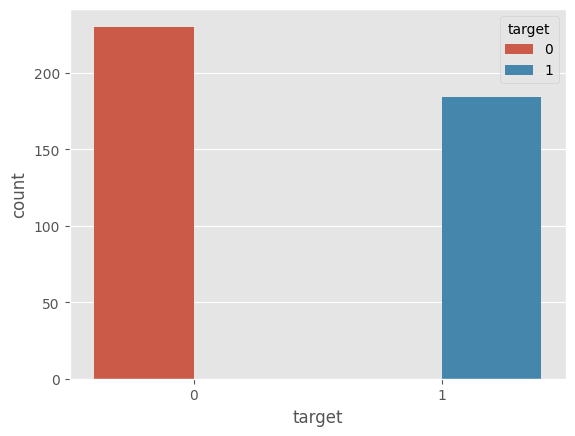

In [6]:
sns.countplot(x = 'target', hue= 'target', data=train)

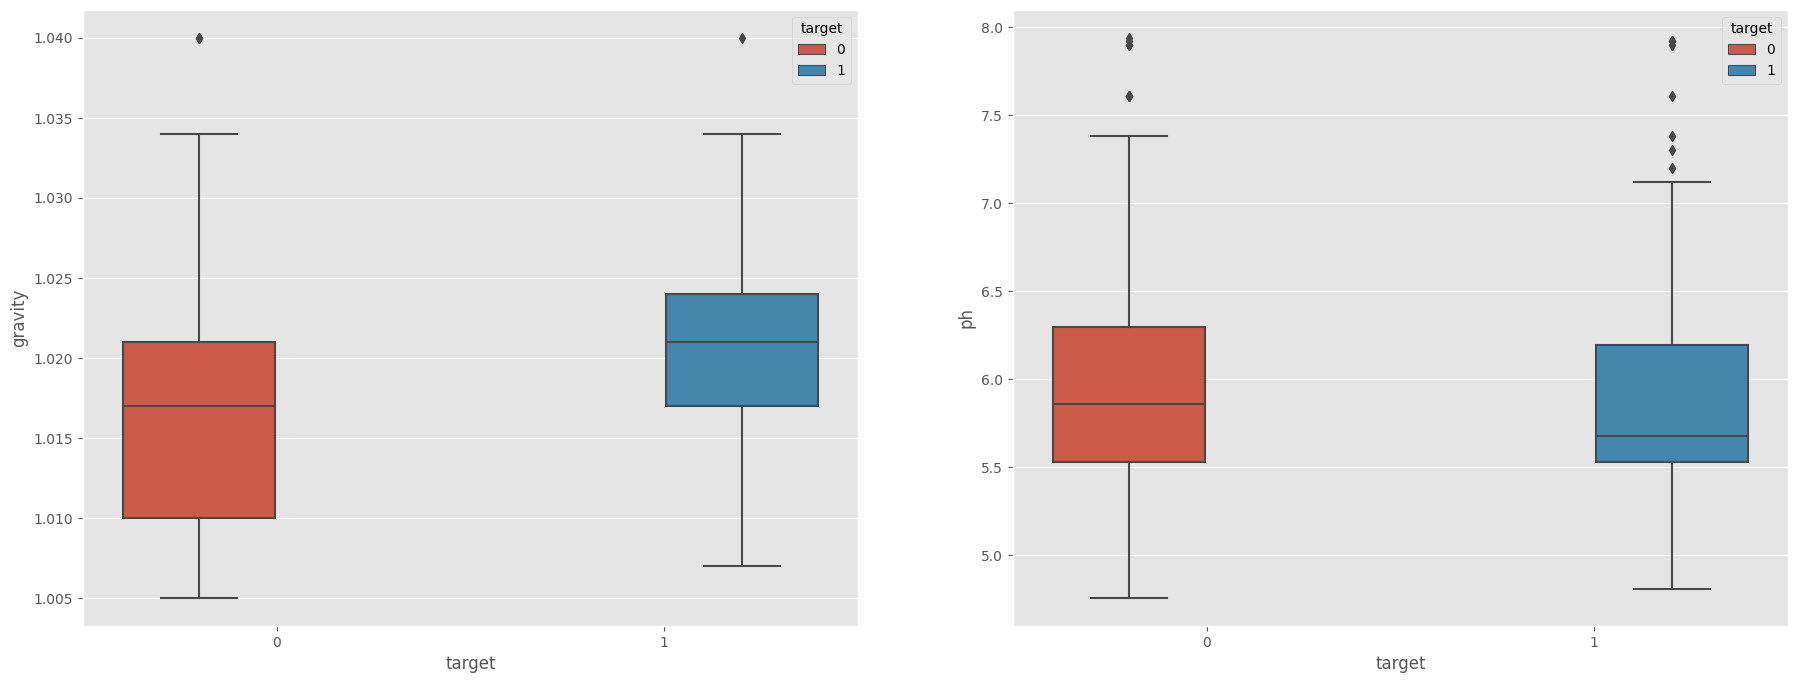

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'target', y = 'gravity', hue = 'target', data = train)
sns.boxplot(ax = axes[1], x = 'target', y = 'ph', hue = 'target', data = train);

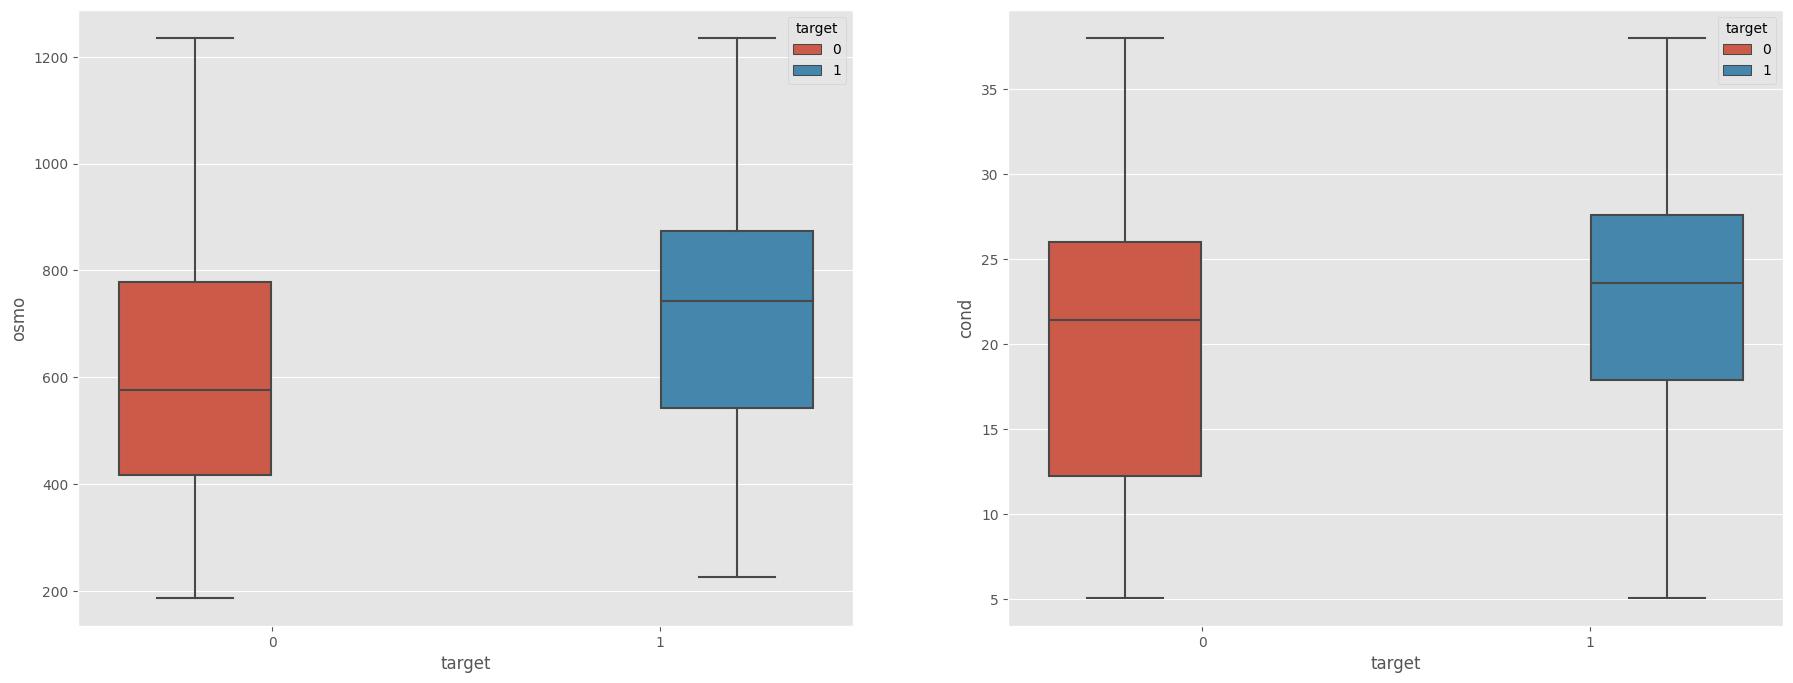

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'target', y = 'osmo', hue = 'target', data = train)
sns.boxplot(ax = axes[1], x = 'target', y = 'cond', hue = 'target', data = train);

<AxesSubplot: xlabel='target', ylabel='calc'>

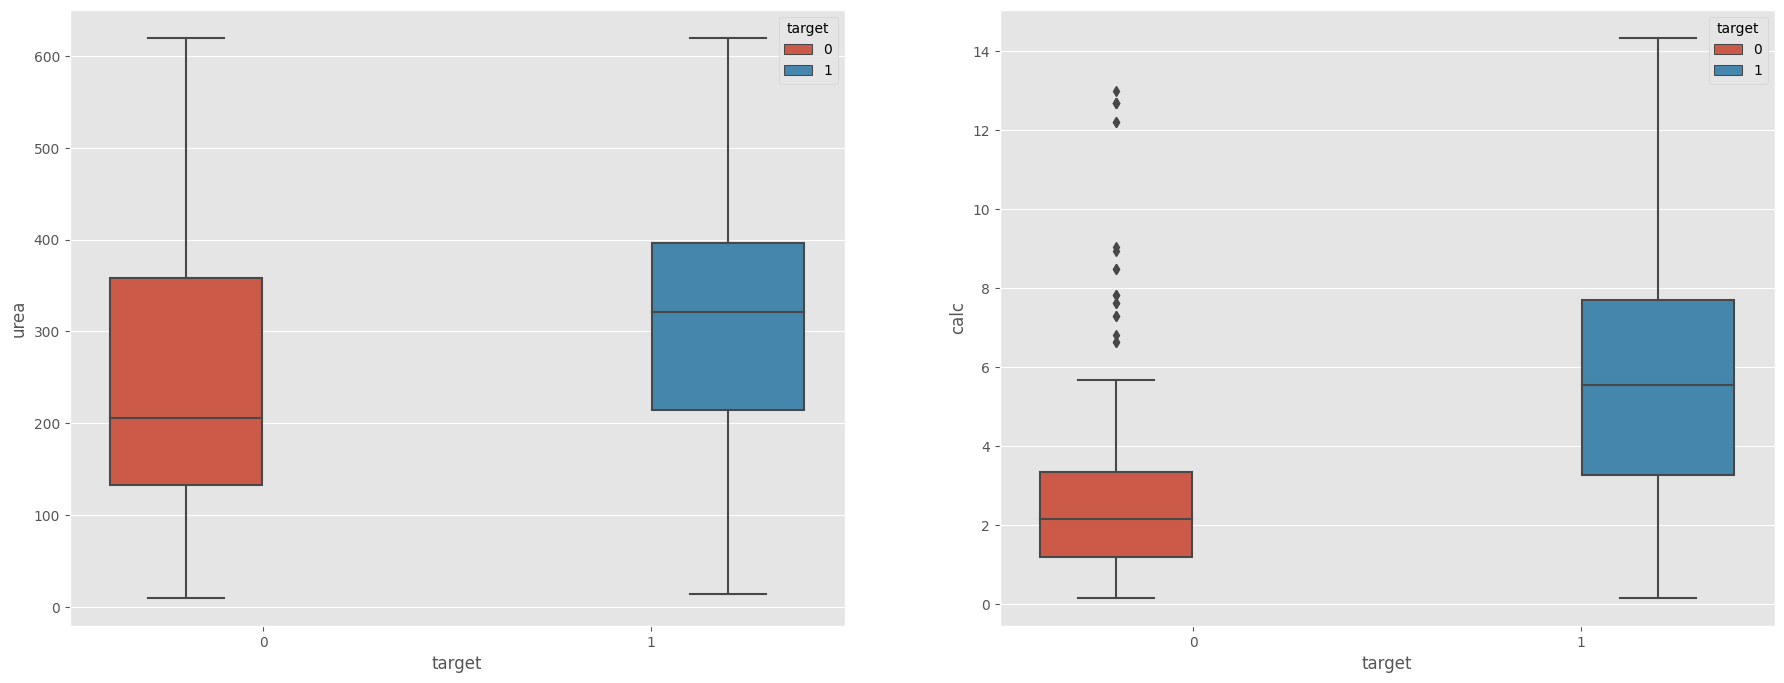

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))

sns.boxplot(ax = axes[0], x = 'target', y = 'urea', hue = 'target', data = train)
sns.boxplot(ax = axes[1], x = 'target', y = 'calc', hue = 'target', data = train)


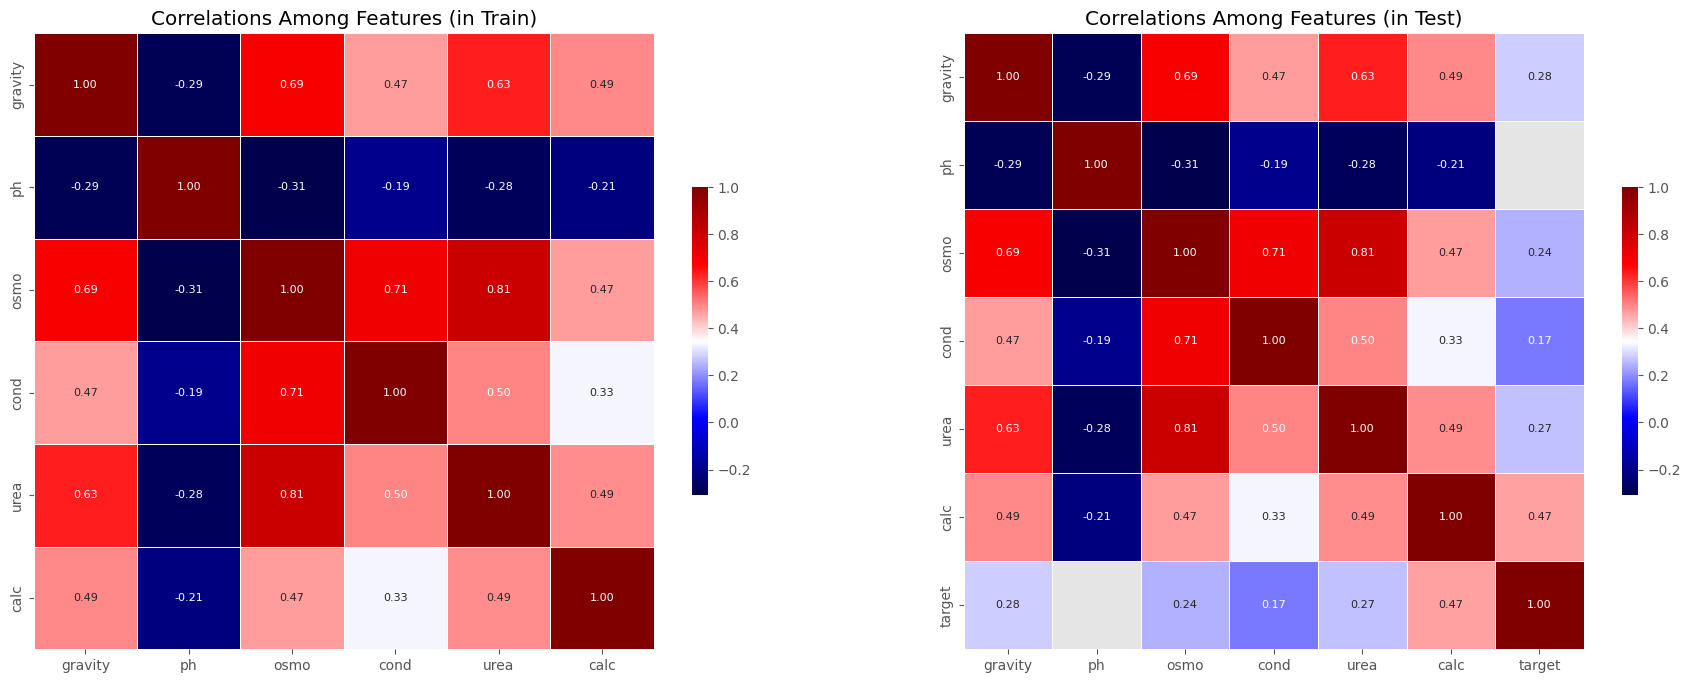

In [10]:
corr_mat_train = train.drop(columns=['id', 'target'], axis=1).corr()
corr_mat_test = train.drop(columns=['id'], axis=1).corr()
threshold = 0.1
corr_threshold_train = corr_mat_train[(corr_mat_train > threshold) | (corr_mat_train < -threshold)]
corr_threshold_test = corr_mat_test[(corr_mat_test > threshold) | (corr_mat_test < -threshold)]

fig, axes = plt.subplots(1, 2, figsize = (22, 8))
sns.heatmap(corr_threshold_train, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Correlations Among Features (in Train)')
sns.heatmap(corr_threshold_test, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Features (in Test)');

<AxesSubplot: xlabel='calc', ylabel='Density'>

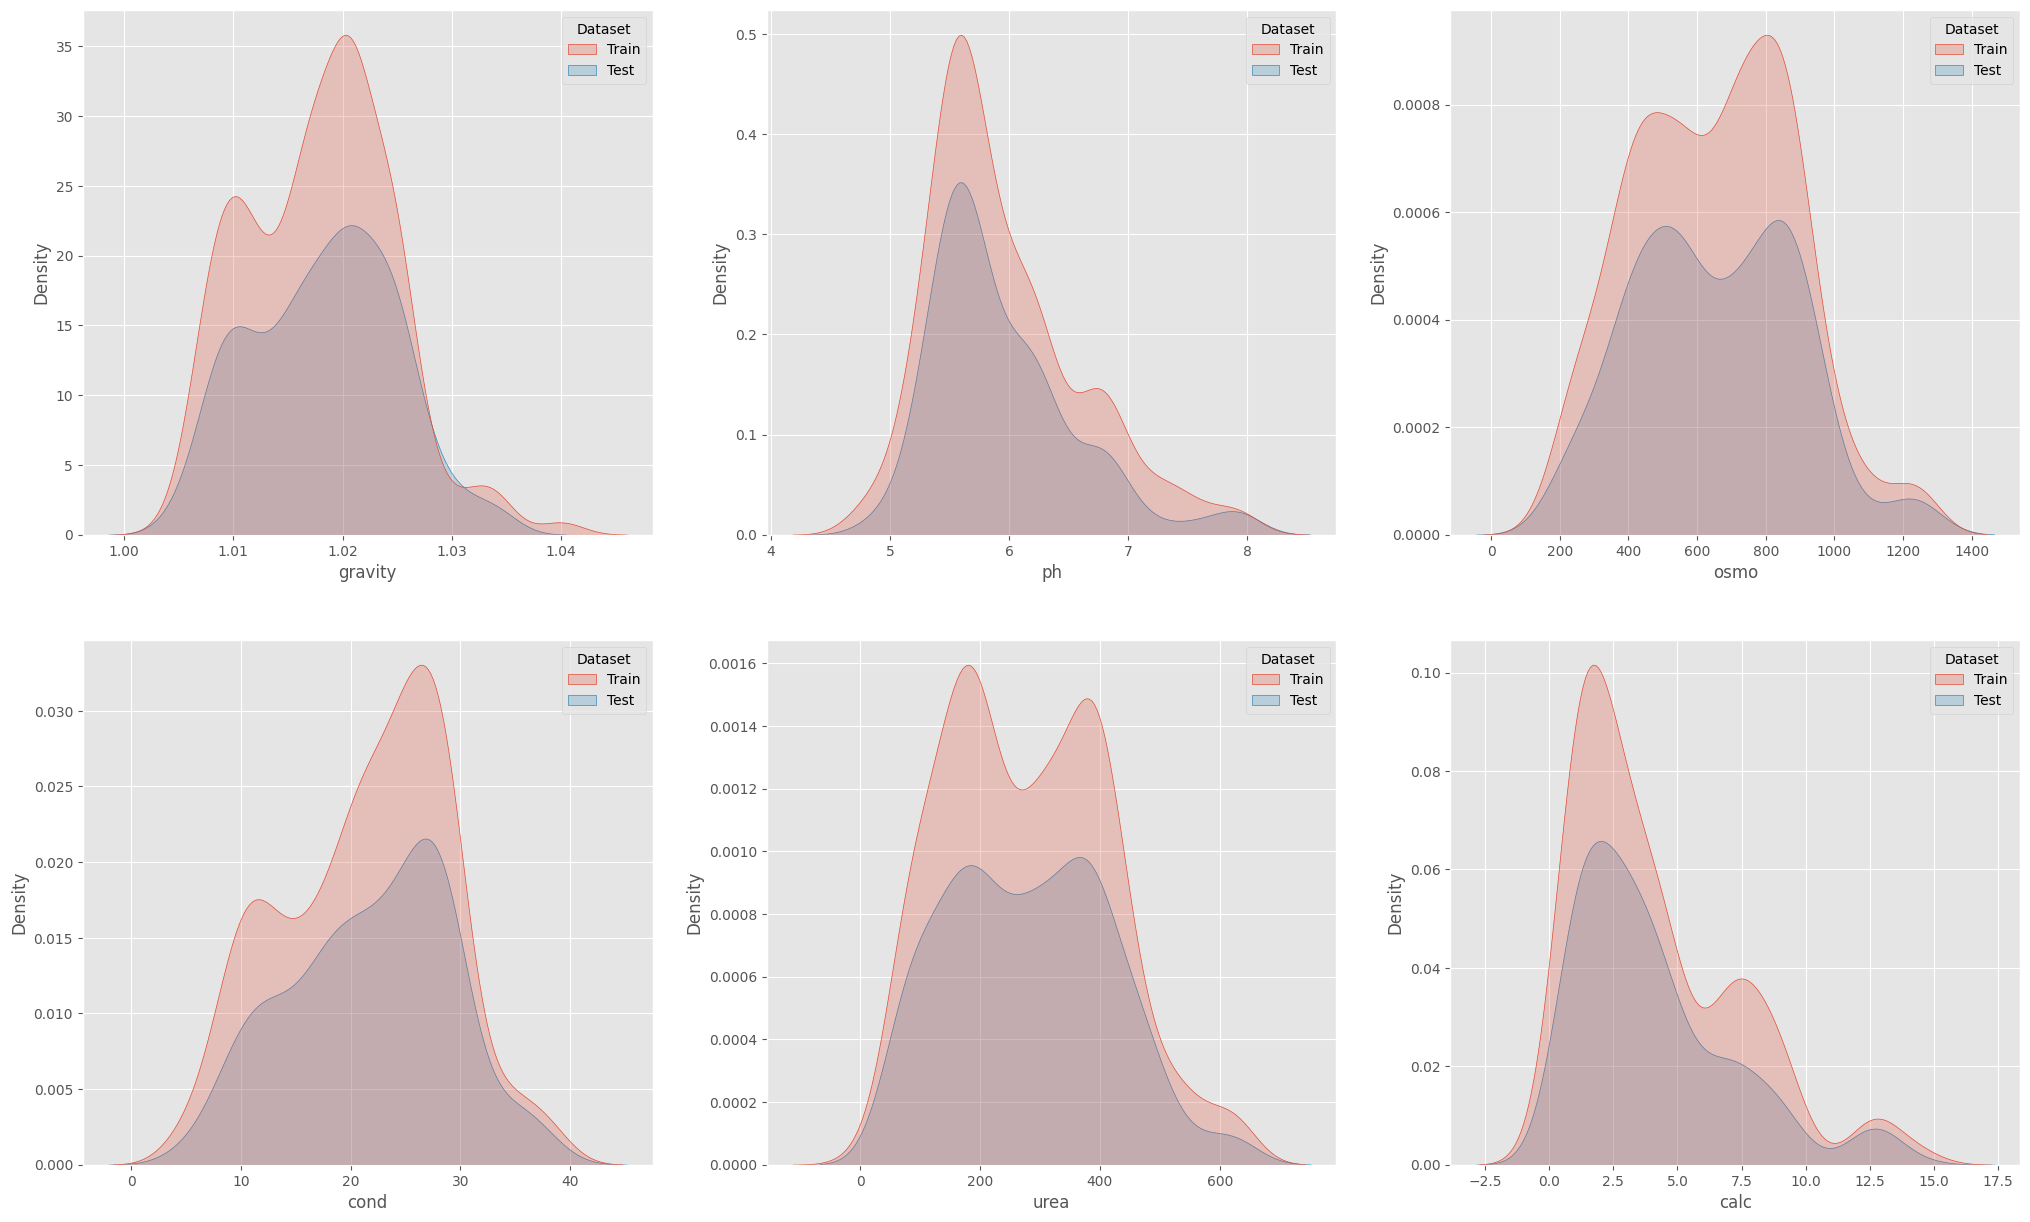

In [11]:
train_vis = train.drop(columns = ['id', 'target'], axis = 1).reset_index(drop = True).copy()
test_vis = test.drop(columns = ['id'], axis = 1).reset_index(drop = True).copy()

train_vis['Dataset'] = 'Train'
test_vis['Dataset'] = 'Test'
data_tot = pd.concat([train_vis, test_vis], axis = 0).reset_index(drop = True)
fig, axes = plt.subplots(2, 3, figsize = (25, 15))

sns.kdeplot(ax = axes[0, 0], x = 'gravity', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'ph', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'osmo', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'cond', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'urea', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'calc', hue = 'Dataset', data = data_tot, fill = True)

In [14]:
X = train.drop(columns = ['id', 'target'], axis = 1)
Y = train['target']

test_baseline = test.drop(columns = ['id'], axis = 1)
cv_scores, roc_auc_scores = list(), list()
preds = list()

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_idx, test_idx) in enumerate(skf.split(X, Y)):

    ## Splitting the data 
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
                
    ## Building LightGBM model
    model = LGBMClassifier(n_estimators = 500,
                           max_depth = 4,
                           learning_rate = 0.01,
                           num_leaves = 20,
                           reg_alpha = 3,
                           reg_lambda = 3,
                           subsample = 0.7,
                           colsample_bytree = 0.7).fit(X_train, Y_train)
        
    ## Predicting on X_test and test
    model_pred_1 = model.predict_proba(X_test)[:, 1]
    model_pred_2 = model.predict_proba(test_baseline)[:, 1]
        
    ## Computing roc-auc score
    score = roc_auc_score(Y_test, model_pred_1)
    roc_auc_scores.append(score)
    preds.append(model_pred_2)
        
    print('Fold', i, '==> roc-auc-score is ==>', score)
        
cv_scores.append(np.mean(roc_auc_scores))
lgb_cv_score = np.mean(cv_scores)    
print('The oof average roc-auc-score of the LightGBM model over 10-folds is:', lgb_cv_score)

Fold 0 ==> roc-auc-score is ==> 0.7048054919908467
Fold 1 ==> roc-auc-score is ==> 0.7322654462242563
Fold 2 ==> roc-auc-score is ==> 0.7551487414187643
Fold 3 ==> roc-auc-score is ==> 0.816933638443936
Fold 4 ==> roc-auc-score is ==> 0.7874396135265701
Fold 5 ==> roc-auc-score is ==> 0.8164251207729469
Fold 6 ==> roc-auc-score is ==> 0.8526570048309179
Fold 7 ==> roc-auc-score is ==> 0.8623188405797102
Fold 8 ==> roc-auc-score is ==> 0.7922705314009661
Fold 9 ==> roc-auc-score is ==> 0.8442028985507246
The oof average roc-auc-score of the LightGBM model over 10-folds is: 0.7964467327739639


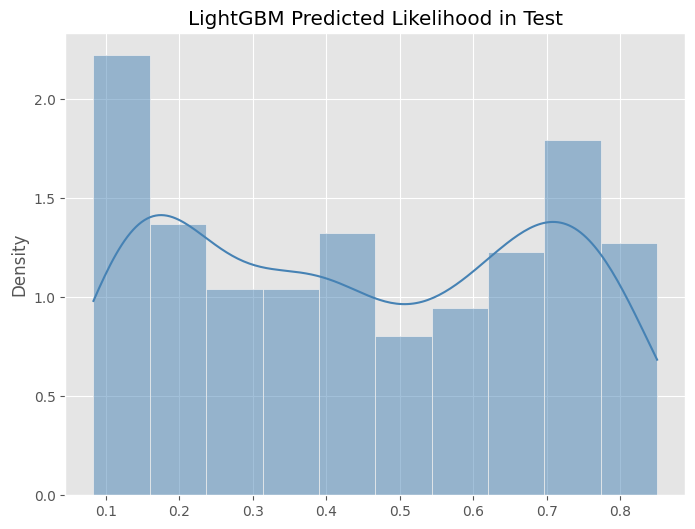

In [15]:
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

plt.figure(figsize = (8, 6))
sns.histplot(data = lgb_preds_test, kde = True, stat = 'density', color = 'steelblue').set(title = 'LightGBM Predicted Likelihood in Test');


In [16]:
submission['target'] = lgb_preds_test
submission.to_csv('lgb_baseline_submission.csv', index = False)